Load necessary libraries

In [1]:
import pandas as pd
import umap
from sklearn.manifold import TSNE
import numpy as np
from sklearn import preprocessing
from sklearn import decomposition
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import time
import random

Load cell types

In [2]:
cell_type = []
for chunk in pd.read_csv("./tabula_muris_drop_meta.csv", chunksize=3, usecols = [0], dtype = "str", header = 0):
    cell_type += chunk.values.tolist()

Load data (takes a while)

In [3]:
cols = pd.read_csv("./tabula_muris_drop.csv", nrows = 1, header = 0).columns
# set index first, then read all without index
index = pd.read_csv("./tabula_muris_drop.csv", index_col=False, dtype = "str", header=0, \
                    usecols=[0], squeeze=True)
expression = pd.read_csv("./tabula_muris_drop.csv", index_col=False, dtype = "float", \
                         header=0, usecols=cols[1:])
expression = expression.set_index(index)

In [4]:
cols = [c for c in expression.columns if not c.startswith('ERCC') and not c.endswith("transgene")]
expression = expression[cols]
expression = expression[expression.columns[expression.sum(axis=0) != 0]]
expression.shape

(54837, 19815)

Convert to log2 expression

In [5]:
logexpression = np.log2(expression+1)

Run PCA (centered, not scaled)

In [6]:
scaled_exp = preprocessing.scale(logexpression, with_std=False)
start_time = time.time()
pca = decomposition.PCA(n_components=40)
pca.fit(scaled_exp)
pca_data = pca.transform(scaled_exp)
print("--- %s seconds ---" % (time.time() - start_time))
pd.DataFrame(pca_data).to_csv("dimRed_mats/pca_mat.csv")

--- 61.24016237258911 seconds ---


Run and count time for tSNE; save matrix

In [7]:
start_time = time.time()
random.seed(1)
tsne_data = TSNE(n_components=2).fit_transform(pca_data)
print("--- %s seconds ---" % (time.time() - start_time))
pd.DataFrame(tsne_data).to_csv("dimRed_mats/tsne_mat.csv")

--- 1103.7511825561523 seconds ---


Running UMAP with several metrics

In [8]:
metrics = ["chebyshev","minkowski","canberra","sokalsneath","euclidean",
           "hamming","jaccard","rogerstanimoto","cosine","correlation"]
for m in metrics:
    start_time = time.time()
    random.seed(1)
    umap_data = umap.UMAP(n_neighbors=10, min_dist=0.3, metric=m, random_state=1).fit_transform(pca_data)
    print("--- %s seconds ---" % (time.time() - start_time))
    pd.DataFrame(umap_data).to_csv("dimRed_mats/umap_"+m+"_mat.csv")

--- 63.07843828201294 seconds ---
--- 61.045427560806274 seconds ---
--- 64.52216076850891 seconds ---
--- 165.91101813316345 seconds ---
--- 60.71138262748718 seconds ---
--- 127.10633540153503 seconds ---
--- 167.75579190254211 seconds ---
--- 165.6954460144043 seconds ---
--- 61.270735025405884 seconds ---
--- 62.19476771354675 seconds ---


Briefly comparing other parameters - base will be euclidean

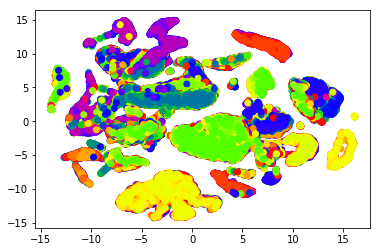

In [9]:
random.seed(1)
umap_data = umap.UMAP(n_neighbors=10, min_dist=0.3, metric="euclidean", random_state=1).fit_transform(pca_data)
cmap = plt.get_cmap('prism')
colors = cmap(np.linspace(0, 1, len(cell_type)))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(umap_data[:,0], umap_data[:,1], c=colors)

How does an increase in spread affect it?

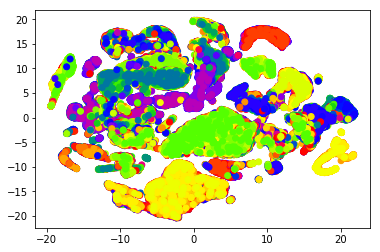

In [10]:
random.seed(1)
umap_data = umap.UMAP(n_neighbors=10, min_dist=0.3, metric="euclidean", spread = 2, random_state=1).fit_transform(pca_data)
cmap = plt.get_cmap('prism')
colors = cmap(np.linspace(0, 1, len(cell_type)))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(umap_data[:,0], umap_data[:,1], c=colors)

And a decrease?

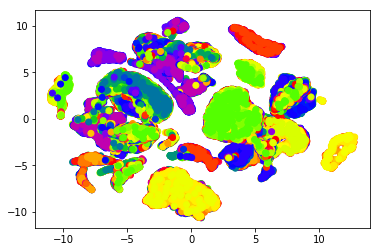

In [11]:
random.seed(1)
umap_data = umap.UMAP(n_neighbors=10, min_dist=0.3, metric="euclidean", spread = 0.5, random_state=1).fit_transform(pca_data)
cmap = plt.get_cmap('prism')
colors = cmap(np.linspace(0, 1, len(cell_type)))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(umap_data[:,0], umap_data[:,1], c=colors)

And how would a plot with random initialization look like

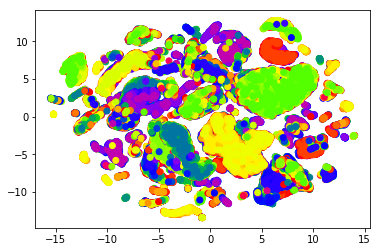

In [12]:
random.seed(1)
umap_data = umap.UMAP(n_neighbors=10, min_dist=0.3, metric="euclidean", init="random", random_state=1).fit_transform(pca_data)
cmap = plt.get_cmap('prism')
colors = cmap(np.linspace(0, 1, len(cell_type)))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(umap_data[:,0], umap_data[:,1], c=colors)

Finally, let's get a 3D UMAP for plotting later

In [13]:
m = "euclidean"
start_time = time.time()
random.seed(1)
umap_data = umap.UMAP(n_neighbors=10, min_dist=0.3, metric=m, random_state=1, n_components=3).fit_transform(pca_data)
print("--- %s seconds ---" % (time.time() - start_time))
pd.DataFrame(umap_data).to_csv("dimRed_mats/umap_"+m+"_mat3D.csv")

--- 63.760254859924316 seconds ---
